# Contents
본 단계에서는 전처리된 데이터를 기반으로 log_members(인기)를 예측하는 선형 회귀 모델을 구축한다.
EDA에서 도출된 가설을 통계적으로 검증하는 것을 목표로 한다.

- 1. Import Processed Data
- 2. Feature Selection
- 3. Train-Test Split
- 4. OLS Regression
- 5. Multicollinearity Check (VIF)
- 6. Model Refinement
- 7. Residual Diagnostics
- 8. Model Interpretation
- 9. Conclusion

# 1. Import Processed Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import mysql.connector

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../data/processed/feature_anime.csv")

df.head()

,anime_id,title,score,members,type,episodes,start_date,popularity,genre_count,company_count,studio_count,producer_count,voice_actor_count,japanese_va_count,year,log_members
0,1,Cowboy Bebop,8.75,2014470,TV,26,1998-01-01,42,5,4,1,3,18,18,1998,14.515867
1,5,Cowboy Bebop: Tengoku no Tobira,8.38,404634,Movie,1,2001-01-01,650,4,3,1,2,17,17,2001,12.910741
2,6,Trigun,8.22,817570,TV,26,1998-01-01,265,4,3,1,2,18,18,1998,13.614093
3,7,Witch Hunter Robin,7.23,126303,TV,26,2002-01-01,1982,4,4,1,3,15,15,2002,11.746447
4,8,Bouken Ou Beet,6.92,16486,TV,52,2004-01-01,5773,4,3,1,2,10,10,2004,9.710327


In [3]:
df.shape

(9999, 16)

# 2. Feature Selection

EDA 결과를 기반으로 다음 변수를 사용한다.

- score
- genre_count
- producer_count
- studio_count
- voice_actor_count
- year
- type (categorical → dummy)

In [4]:
df_model = pd.get_dummies(df, columns = ["type"], drop_first = True, dtype = int)

df_model.columns

Index(['anime_id', 'title', 'score', 'members', 'episodes', 'start_date',
       'popularity', 'genre_count', 'company_count', 'studio_count',
       'producer_count', 'voice_actor_count', 'japanese_va_count', 'year',
       'log_members', 'type_ONA', 'type_OVA', 'type_Special', 'type_TV',
       'type_TV Special'],
      dtype='object')

In [5]:
features = [
    "score",
    "genre_count",
    "producer_count",
    "studio_count",
    "voice_actor_count",
    "year"
] + [col for col in df_model.columns if col.startswith("type_")]

X = df_model[features]
y = df_model["log_members"]

X.shape, y.shape

((9999, 11), (9999,))

# 3. Train-Test Split

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.shape, X_test.shape

((7999, 11), (2000, 11))

# 4. OLS Regression


In [7]:
import statsmodels.api as sm

X_train_const = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train_const).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_members   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1167.
Date:                Mon, 23 Feb 2026   Prob (F-statistic):               0.00
Time:                        00:21:47   Log-Likelihood:                -12841.
No. Observations:                7999   AIC:                         2.571e+04
Df Residuals:                    7987   BIC:                         2.579e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -56.2669      2.607    -21.584      0.000     -61.377     -51.157
score                 1.4682      0.024     62.002      0.000       1.422       1.515
genre_count           0.1555      0.007     21.845      0.000       0.142       0.169
producer_count        0.1779      0.007     25.084      0.000       0.164       0.192
studio_count         -0.2423      0.033     -7.276      0.000      -0.308      -0.177
voice_actor_count     0.0037      0.001      5.934      0.000       0.002       0.005
year                  0.0272      0.001     20.730      0.000       0.025       0.030
type_ONA             -0.8544      0.053    -16.043      0.000      -0.959      -0.750
type_OVA              0.4846      0.052      9.374      0.000       0.383       0.586
type_Special          0.3613      0.054      6.639      0.000       0.255       0.468
type_TV               0.8836      0.039     22.432      0.000       0.806       0.961
type_TV Special       0.0490      0.073      0.674      0.500      -0.093       0.191
==============================================================================
Omnibus:                       51.006   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.884
Skew:                           0.183   Prob(JB):                     8.93e-12
Kurtosis:                       2.863   Cond. No.                     3.89e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.89e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## OLS Regression Results Interpretation

### 1. Model Performance

- R-squared = 0.616  
- Adj. R-squared = 0.616  
- F-statistic p-value < 0.001  

본 모델은 log_members(인기)의 약 61.6%를 설명하며, 모델 전체는 통계적으로 유의하다.  
이는 선형 회귀 모델로서 충분한 설명력을 가진 것으로 판단된다.

---

### 2. Key Significant Variables

#### (1) Score
- coef = 1.468
- p < 0.001

평점은 인기의 가장 강력한 설명 변수로 나타났다.  
평점이 1점 증가할 때 log_members는 약 1.47 증가하는 경향을 보인다.

---

#### (2) Producer Count
- coef = 0.178
- p < 0.001

제작 참여 규모가 클수록 작품의 인기가 증가하는 경향이 있다.  
이는 투자 규모 및 산업적 네트워크 효과와 관련될 가능성이 있다.

---

#### (3) Genre Count
- coef = 0.156
- p < 0.001

복합 장르 작품일수록 인기 수준이 다소 높아지는 경향이 확인되었다.

---

#### (4) Year
- coef = 0.027
- p < 0.001

최근 작품일수록 평균적인 인기가 높게 나타난다.  
이는 애니메이션 시장의 장기적 성장 효과를 반영하는 것으로 해석된다.

---

### 3. Type Effects

type 변수는 더미 변수로 변환하였으며, 다중공선성을 방지하기 위해 하나의 범주를 기준(reference category)으로 설정하였다. 
따라서 각 type 계수는 기준 유형 대비 상대적 효과를 의미한다. 본 모델에서는 Movie 유형을 기준 범주로 설정하였다.


작품 유형은 인기 수준에 구조적 차이를 보였다.

- TV: 긍정적 효과
- OVA: 긍정적 효과
- ONA: 부정적 효과
- TV Special: 통계적으로 유의하지 않음

특히 TV 시리즈는 다른 유형 대비 높은 인기를 보이는 경향이 있다.


---

### 4. Additional Observations

- Studio Count는 음의 계수를 보이며 통계적으로 유의하다.  
  이는 제작 구조가 복잡할수록 반드시 흥행으로 이어지지 않을 가능성을 시사한다.

- Voice Actor Count는 통계적으로 유의하지만, 효과 크기는 매우 작다.  
  단순한 성우 참여 수는 인기의 주요 결정 요인이 아닌 것으로 보인다.

---

### 5. Preliminary Conclusion

본 1차 OLS 모델은 주요 산업적 요인(평점, 제작 규모, 장르 다양성, 연도 효과)을 
유의미하게 포착하였다.  

다만, 다중공선성 여부 및 변수 선택 정제 과정을 추가로 수행할 필요가 있다.

# 5. Multicollinearity Check (VIF)


In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# 상수항 추가한 전체 X 사용
X_vif = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]

vif_data

,feature,VIF
0,const,37161.434788
1,score,1.189138
2,genre_count,1.115469
3,producer_count,1.390587
4,studio_count,1.032945
5,voice_actor_count,1.041223
6,year,1.381162
7,type_ONA,1.798200
8,type_OVA,1.510507
9,type_Special,1.481089


## Multicollinearity Check (VIF)

다중공선성 여부를 확인하기 위해 Variance Inflation Factor(VIF)를 계산하였다.

### VIF Interpretation

- 대부분의 변수에서 VIF 값이 1~2 수준으로 나타났다.
- 일반적으로 VIF < 5이면 다중공선성 문제가 없는 것으로 판단한다.
- 본 모델에서는 모든 설명 변수가 해당 기준을 충분히 만족하였다.

특히 다음 변수들 또한 안정적인 수준을 보였다:

- producer_count: VIF ≈ 1.39  
- year: VIF ≈ 1.38  
- type 변수들: VIF ≈ 1.2 ~ 2.1  

이는 변수 간 중복 정보가 거의 없음을 의미한다.

### Conclusion

본 모델에서는 다중공선성 문제가 관찰되지 않았으며,  
현재 변수 구성은 통계적으로 안정적인 상태로 판단된다.

※ 상수항(const)의 VIF 값은 구조적으로 크게 나타날 수 있으며, 다중공선성 판단 대상에서 제외하였다.

# 6. Model Refinement
   - Remove Non-significant Variable (type_TV Special)

In [11]:
features_refined = [f for f in features if f != "type_TV Special"]

X_refined = df_model[features_refined]
y = df_model["log_members"]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_refined, y, test_size = 0.2, random_state = 42)

In [13]:
import statsmodels.api as sm

X_train_const = sm.add_constant(X_train)
model_refined = sm.OLS(y_train, X_train_const).fit()

model_refined.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_members   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1283.
Date:                Mon, 23 Feb 2026   Prob (F-statistic):               0.00
Time:                        01:01:49   Log-Likelihood:                -12842.
No. Observations:                7999   AIC:                         2.571e+04
Df Residuals:                    7988   BIC:                         2.578e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -56.3937      2.600    -21.689      0.000     -61.490     -51.297
score                 1.4664      0.024     62.306      0.000       1.420       1.513
genre_count           0.1557      0.007     21.910      0.000       0.142       0.170
producer_count        0.1775      0.007     25.099      0.000       0.164       0.191
studio_count         -0.2432      0.033     -7.307      0.000      -0.308      -0.178
voice_actor_count     0.0037      0.001      5.951      0.000       0.002       0.005
year                  0.0273      0.001     20.861      0.000       0.025       0.030
type_ONA             -0.8655      0.051    -17.087      0.000      -0.965      -0.766
type_OVA              0.4744      0.049      9.598      0.000       0.378       0.571
type_Special          0.3507      0.052      6.731      0.000       0.249       0.453
type_TV               0.8739      0.037     23.831      0.000       0.802       0.946
==============================================================================
Omnibus:                       50.327   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.182
Skew:                           0.181   Prob(JB):                     1.27e-11
Kurtosis:                       2.863   Cond. No.                     3.88e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.88e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model Refinement Results

통계적으로 유의하지 않았던 type_TV Special 변수를 제거한 후 모델을 재적합하였다.

Refined 모델의 R-squared 및 Adjusted R-squared 값은 초기 모델과 동일하게 유지되었다.
이는 해당 변수가 모델 설명력에 실질적인 기여를 하지 않았음을 의미한다.

주요 변수들의 계수 및 유의성은 안정적으로 유지되었으며,
모델은 더 단순하고 해석 가능한 구조로 정제되었다.

따라서 본 정제 모델을 최종 분석 모델로 채택하였다.

# 7. Residual Diagnostics


In [15]:
# 잔차 계산
residuals = model_refined.resid
fitted = model_refined.fittedvalues

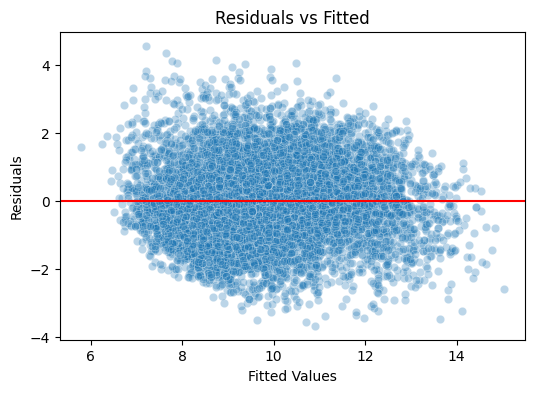

In [ ]:
# 선형성 & 등분산성
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (6, 4))
sns.scatterplot(x = fitted, y = residuals, alpha = 0.3)
plt.axhline(0, color = 'red')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

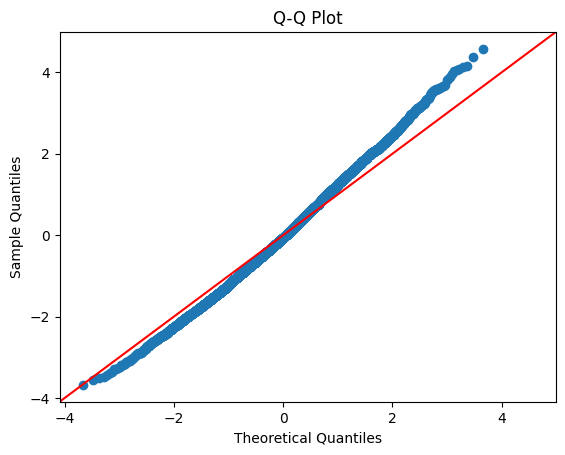

In [17]:
# 정규성 (Q-Q Plot)
import statsmodels.api as sm

sm.qqplot(residuals, line = '45')
plt.title("Q-Q Plot")
plt.show()

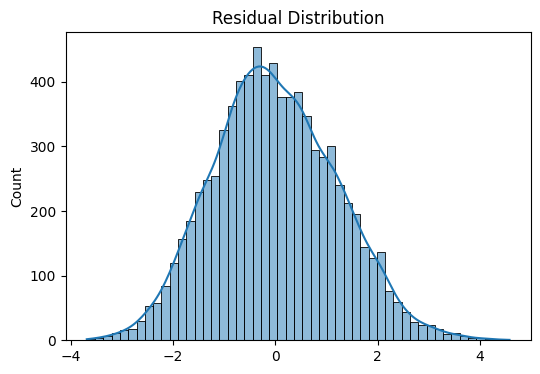

In [ ]:
# 히스토그램 
plt.figure(figsize = (6, 4))
sns.histplot(residuals, kde = True)
plt.title("Residual Distribution")
plt.show()

## Residual Diagnostics

잔차 진단 결과, 본 모델은 선형회귀의 주요 가정을 대체로 만족하는 것으로 판단된다.

- Residuals vs Fitted 플롯에서 잔차는 0을 중심으로 비교적 랜덤하게 분포하며,
  뚜렷한 비선형 패턴은 관찰되지 않았다.

- Q-Q Plot에서는 중앙부가 이론적 직선에 잘 부합하였으며,
  양쪽 꼬리에서 약간의 이탈이 있으나 심각한 수준은 아니다.

- 잔차 분포는 대체로 종 모양을 보이며 평균 0 근처에 위치한다.

따라서 본 모델은 통계적으로 안정적인 회귀 모델로 판단된다.

# 8. Model Interpretation


## Model Interpretation

본 회귀 모델은 애니메이션 작품의 인기(log_members)를 설명하는 주요 요인을 통계적으로 도출하였다.

### 1. 평점의 영향

평점(score)은 가장 강력한 설명 변수로 나타났다.  
평점이 1점 증가할 경우 log_members는 약 1.47 증가한다.

이는 작품의 질적 평가가 팬덤 형성과 직결되는 핵심 요인임을 시사한다.

---

### 2. 제작 규모의 영향

producer_count는 통계적으로 유의하며 긍정적 효과를 보였다.

이는 제작 참여 규모가 클수록 마케팅·유통 네트워크가 확장되고,
산업적 자본이 집중되는 경향이 반영된 결과로 해석된다.

반면 studio_count는 음의 계수를 보였다.

이는 단순한 제작 스튜디오 수 증가가 반드시 흥행으로 이어지지 않음을 의미한다.
복잡한 제작 구조가 효율성을 저하시킬 가능성도 고려할 수 있다.

---

### 3. 장르 다양성

genre_count는 긍정적인 영향을 보였다.

복합 장르 작품은 다양한 타겟층을 확보할 가능성이 있으며,
이는 인기 확장에 기여하는 요인으로 해석된다.

---

### 4. 연도 효과 (산업 성장 효과)

year 변수는 통계적으로 유의하며 양의 계수를 가진다.

이는 최근 작품일수록 평균적으로 높은 인기를 보이는 경향을 의미하며,
글로벌 플랫폼 확장 및 시장 규모 성장의 영향을 반영하는 것으로 해석된다.

---

### 5. 작품 유형 효과

TV 시리즈는 기준 유형 대비 가장 높은 긍정적 효과를 보였다.

반면 ONA는 상대적으로 낮은 인기 수준을 보였다.

이는 방송 플랫폼의 도달 범위 및 유통 구조 차이를 반영하는 것으로 해석된다.

---

### 종합 해석

본 모델은 인기 형성에 있어
- 평점(질적 요소)
- 제작 규모(산업적 요소)
- 장르 다양성(콘텐츠 전략)
- 연도 효과(시장 성장 요인)

이 복합적으로 작용함을 보여준다.

단순히 성우 수와 같은 표면적 요소보다는,
구조적 산업 변수와 작품의 질이 더 중요한 설명 요인으로 나타났다.

※ 본 분석은 상관 관계를 기반으로 한 설명 모델이며, 인과 관계를 직접적으로 증명하는 것은 아니다.

# 9. Conclusion

## Conclusion

본 프로젝트는 MyAnimeList 데이터를 활용하여
애니메이션 작품의 인기(log_members)를 설명하는 요인을 통계적으로 분석하였다.

회귀 분석 결과, 인기 형성에는 다음 요인들이 유의미하게 작용하는 것으로 나타났다:

- 평점(score)
- 제작 참여 규모(producer_count)
- 장르 다양성(genre_count)
- 연도 효과(year)
- 작품 유형(type)

특히 평점은 가장 강력한 설명 변수로 확인되었으며,
산업적 구조 변수(제작 규모, 유통 구조) 또한 중요한 역할을 수행하는 것으로 나타났다.

반면, 단순 성우 참여 인원 수는 인기와의 관계가 제한적인 것으로 분석되었다.

잔차 진단 결과, 모델은 선형성·등분산성·정규성 가정을 대체로 만족하며
통계적으로 안정적인 설명 모델로 판단된다.

본 분석은 상관 관계 기반의 설명 모델이며,
향후에는 비선형 모델 또는 머신러닝 기반 접근을 통해
예측 성능을 확장할 수 있을 것이다.